# Melanoma Detection Assignment

## Problem Statement:

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import seaborn as sns
from glob import glob
from tensorflow import keras
from tensorflow.keras import Sequential, layers, Input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

### Loading and Understanding the Dataset

In [5]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/drive')

## Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/drive


#### Importing Skin Cancer Data

In [6]:
# Defining the path for train and test images
## Paths of train and test dataset on Google drive

data_dir_train = pathlib.Path("/content/drive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/drive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

## Paths of train and test dataset on local machine
# data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
# data_dir_test = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [7]:
# Displaying the count of train and test images
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


This assignment uses a dataset of about 2357 images of skin cancer types.
The dataset contains 9 sub-directories in each train and test subdirectories.
The 9 sub-directories contains the images of 9 skin cancer types respectively.

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [8]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [9]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='training',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [10]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='validation',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [11]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Create a code to visualize one instance of all the nine classes present in the dataset

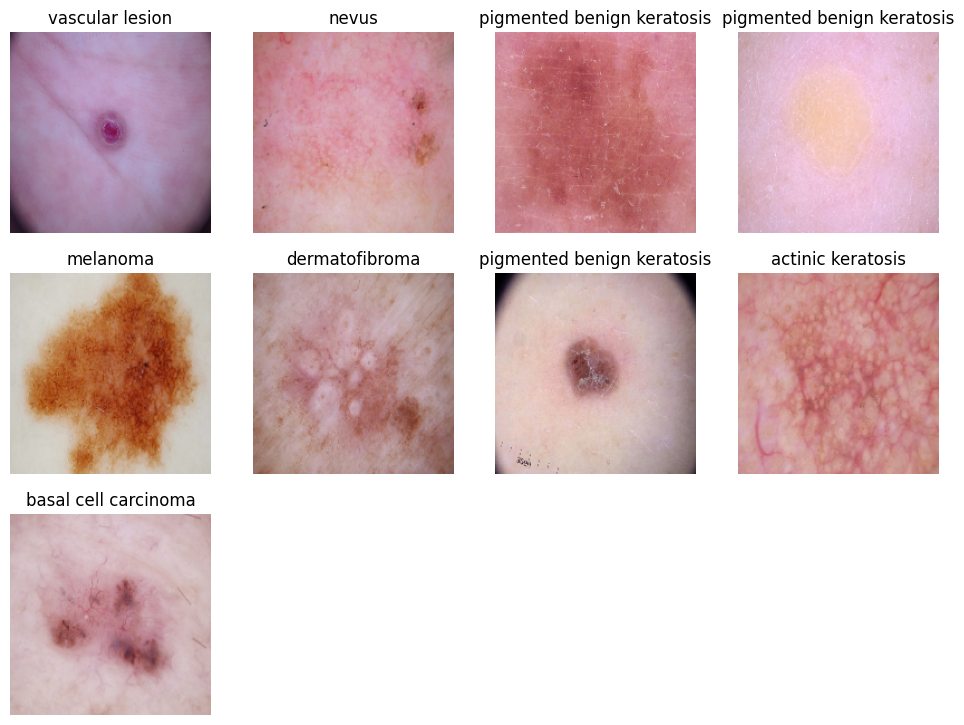

In [12]:
### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [14]:
### Your code goes here
# Number of target labels are 9
target_labels = 9

model = Sequential([
    Input(shape=(img_height, img_width, 3)),  # Define the input shape explicitly
    layers.Rescaling(1.0 / 255),  # Rescaling no longer requires input_shape
    layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation=tf.nn.relu),
    layers.Dense(target_labels)
])


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [15]:
### choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [17]:
%%time
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 402s 1s/step - accuracy: 0.2113 - loss: 2.3165 - val_accuracy: 0.2931 - val_loss: 1.8984
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3263 - loss: 1.8308 - val_accuracy: 0.3714 - val_loss: 1.7219
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4523 - loss: 1.5905 - val_accuracy: 0.5034 - val_loss: 1.4997
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4966 - loss: 1.4163 - val_accuracy: 0.4989 - val_loss: 1.5084
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5404 - loss: 1.3171 - val_accuracy: 0.4452 - val_loss: 1.6036
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5143 - loss: 1.3343 - val_accuracy: 0.5190 - val_loss: 1.4162
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6002 - loss: 1.1552 - val_accuracy: 0.5257 - val_loss: 1.3803
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5945 - loss: 1.1140 - val_accuracy: 0.5257 - v

### Visualizing training results

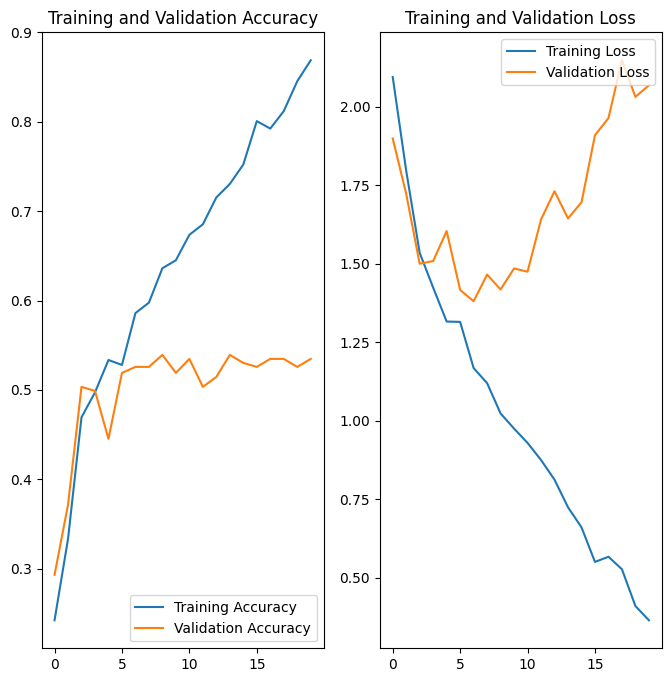

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

***Observations:***

1. The model's training accuracy shows a steady increase of upto 90%, while validation accuracy remains consistently around 55%.

2. A high training accuracy suggests the model has effectively captured the noise within the data. However, its poor performance on validation data indicates a lack of generalizability.

3. These observations confirm the presence of overfitting. To address this issue, augmentation techniques will be employed. Given the limited training data available, new samples will be generated by making slight modifications to existing data (such as horizontal/vertical image flipping, minor image rotations, etc.), which will then be used for training the model.

In [19]:
# After you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here

augmentation_data = Sequential([
    Input(shape=(img_height, img_width, 3)),  # Explicitly define the input shape
    layers.RandomFlip("horizontal"),          # Use non-experimental layers
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])


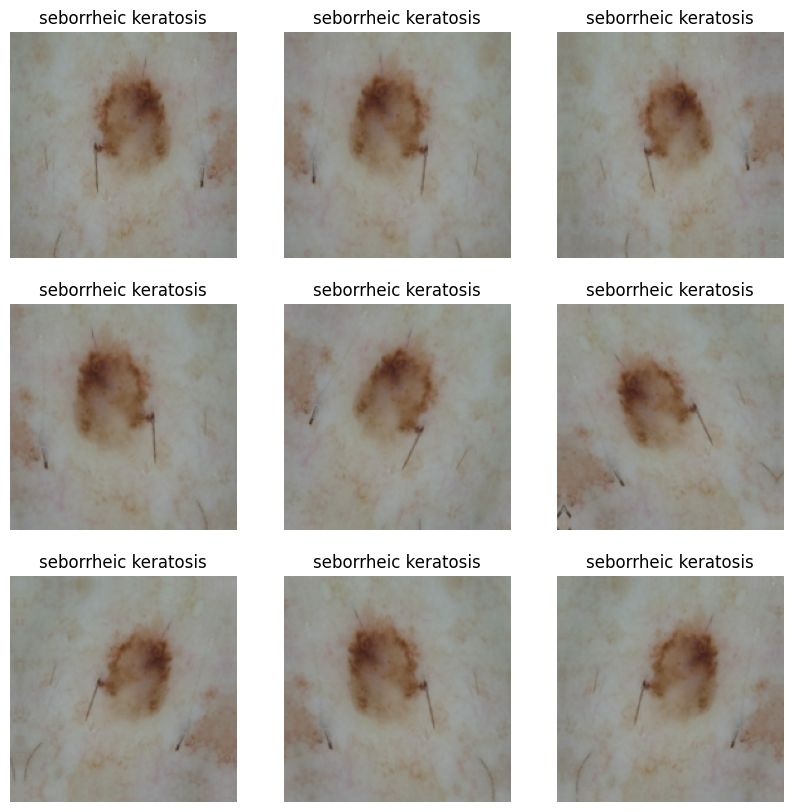

In [20]:
# Visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_images = augmentation_data(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[labels[0]])
        plt.axis("off")

### Create the model, compile and train the model


In [21]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
## Your code goes here
model = Sequential([
    Input(shape=(img_height, img_width, 3)),  # Explicitly define the input shape
    augmentation_data,                       # Data augmentation layer
    layers.Rescaling(1.0 / 255),             # Normalization layer
    layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),                     # Dropout for regularization
    layers.Flatten(),
    layers.Dense(128, activation=tf.nn.relu),
    layers.Dense(target_labels)             # Final output layer
])


### Compiling the model

In [22]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [23]:
%%time
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.2780 - loss: 2.0986 - val_accuracy: 0.3848 - val_loss: 1.7058
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.4055 - loss: 1.6471 - val_accuracy: 0.4340 - val_loss: 1.5660
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.4283 - loss: 1.5982 - val_accuracy: 0.4564 - val_loss: 1.4936
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.4712 - loss: 1.4744 - val_accuracy: 0.4989 - val_loss: 1.4887
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5015 - loss: 1.4510 - val_accuracy: 0.5011 - val_loss: 1.4213
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5219 - loss: 1.3778 - val_accuracy: 0.4452 - val_loss: 1.5923
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.4728 - loss: 1.4609 - val_accuracy: 0.4877 - val_loss: 1.4490
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5286 - loss: 1.3625 - val_accuracy: 0.5190 - v

### Visualizing the results

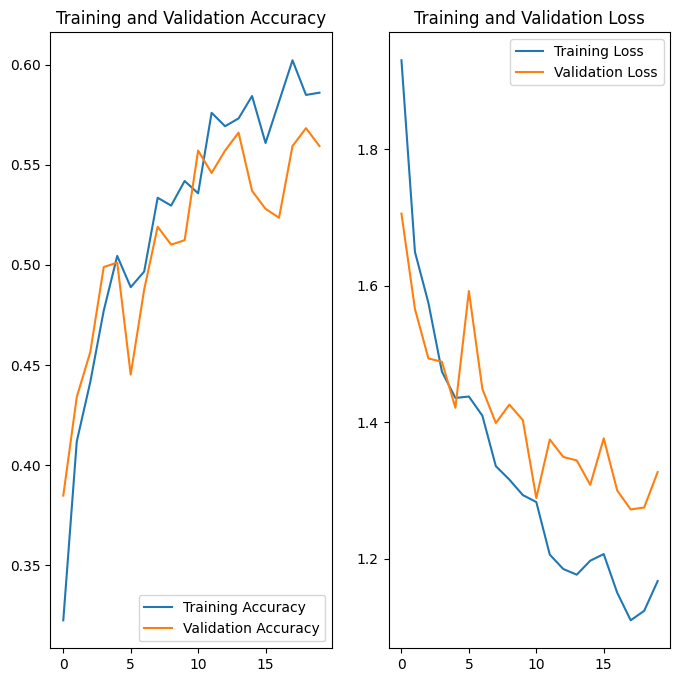

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

***Observations:***

1.Training and Validation Accuracy:

Training accuracy steadily increases over epochs and reaches above 0.60.
Validation accuracy closely follows the trend of training accuracy and shows a similar improvement over epochs, with only slight fluctuations.

2.Training and Validation Loss:

Training loss consistently decreases over epochs, indicating the model is effectively learning from the training data.
Validation loss decreases as well but exhibits some fluctuations, suggesting minor instability in validation performance.

3.Findings:
The model shows evidence of good generalization:

Training and validation accuracy curves are closely aligned, with no significant divergence.
Validation loss does not increase drastically and is closely aligned with the training loss, though with some fluctuations.
There is no strong evidence of overfitting or underfitting in the current training process.

#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [25]:
## Your code goes here.
## find the image path for all class labels (lesions)
images_path_list = [ i for i in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]

## Extract the class labels (lesions)
lesions_list = [ os.path.basename(os.path.dirname(j)) for j in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]
print(len(lesions_list))

2239


In [26]:
# Extract image path and class label in a dictionary
image_dict = dict(zip(images_path_list, lesions_list))
print(list(image_dict.items())[:5])

[('/content/drive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0024475.jpg', 'vascular lesion'), ('/content/drive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0025197.jpg', 'vascular lesion'), ('/content/drive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0024904.jpg', 'vascular lesion'), ('/content/drive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0024747.jpg', 'vascular lesion'), ('/content/drive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0024662.jpg', 'vascular lesion')]


In [27]:
# View the image path and class label in a df
lesions_df = pd.DataFrame(list(image_dict.items()), columns=['Image Path', 'Label'])
lesions_df.head()

,Image Path,Label
0,/content/drive/My Drive/Melanoma Detection Ass...,vascular lesion
1,/content/drive/My Drive/Melanoma Detection Ass...,vascular lesion
2,/content/drive/My Drive/Melanoma Detection Ass...,vascular lesion
3,/content/drive/My Drive/Melanoma Detection Ass...,vascular lesion
4,/content/drive/My Drive/Melanoma Detection Ass...,vascular lesion


In [28]:
## Inspecting the distribution of classes in the data
lesions_df[['Label']].value_counts()

,count
Label,
pigmented benign keratosis,462
melanoma,438
basal cell carcinoma,376
nevus,357
squamous cell carcinoma,181
vascular lesion,139
actinic keratosis,114
dermatofibroma,95
seborrheic keratosis,77


<ipython-input-29-c1823caf3877>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y="Label", data=lesions_df, palette=custom_colors)  # Custom colors


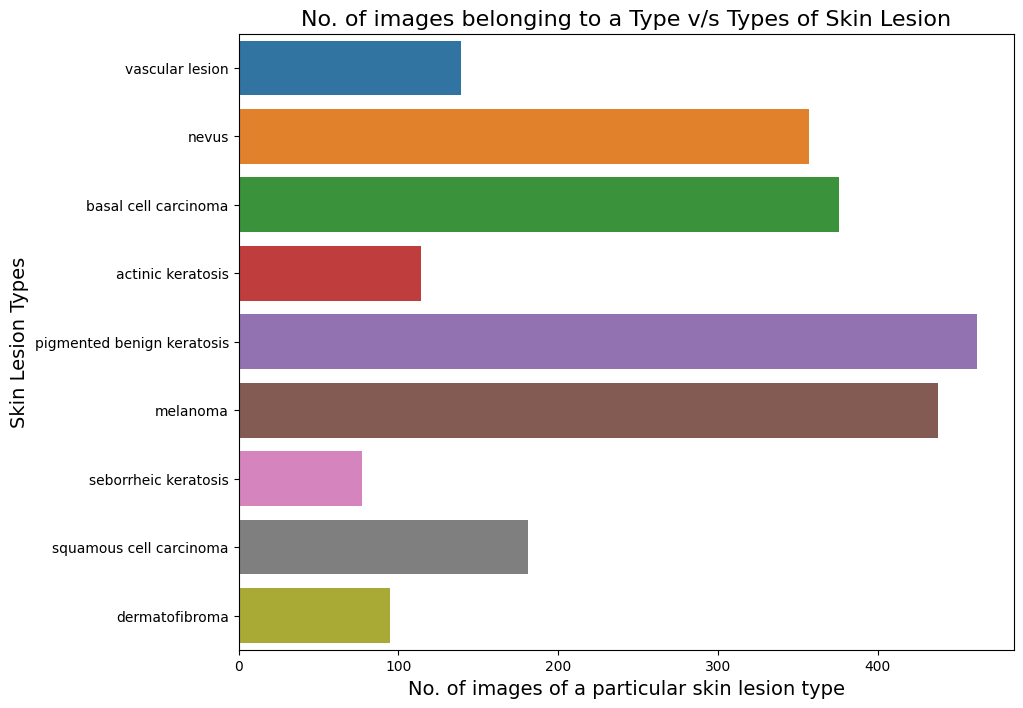

In [29]:
# Visualize the distribution of classes using a countplot
custom_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22"]
plt.figure(figsize=(10, 8))
sns.countplot(y="Label", data=lesions_df, palette=custom_colors)  # Custom colors
plt.title('No. of images belonging to a Type v/s Types of Skin Lesion', fontsize=16)
plt.xlabel('No. of images of a particular skin lesion type', fontsize=14)
plt.ylabel('Skin Lesion Types', fontsize=14)
plt.show()

In [30]:
round(lesions_df[['Label']].value_counts(normalize=True)*100, 2)

,proportion
Label,
pigmented benign keratosis,20.63
melanoma,19.56
basal cell carcinoma,16.79
nevus,15.94
squamous cell carcinoma,8.08
vascular lesion,6.21
actinic keratosis,5.09
dermatofibroma,4.24
seborrheic keratosis,3.44


#### Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


***Observations:***

1. A clear class imbalance is evident within the training data.

2. The class **"seborrheic keratosis"** comprises the smallest proportion of samples, accounting for approximately **3.44%**.

3. **"Pigmented benign keratosis"** and **"melanoma"** significantly outweigh other classes, representing approximately **20.63%** and **19.56%** of the data, respectively.

#### Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [31]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [32]:
path_to_training_dataset = str(data_dir_train) + '/'

import Augmentor

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DDFC3E03B50>: 100%|██████████| 500/500 [00:26<00:00, 18.72 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7DDFC3E47880>: 100%|██████████| 500/500 [00:18<00:00, 26.50 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DDFC3E63460>: 100%|██████████| 500/500 [00:19<00:00, 25.63 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7DDFC3EFDF30>: 100%|██████████| 500/500 [01:35<00:00,  5.24 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2117x1988 at 0x7DDFED3BE020>: 100%|██████████| 500/500 [01:31<00:00,  5.49 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DDFE3DBB430>: 100%|██████████| 500/500 [00:21<00:00, 22.78 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7DDFED3D0A30>: 100%|██████████| 500/500 [00:42<00:00, 11.83 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7DDFE3D23C40>: 100%|██████████| 500/500 [00:20<00:00, 24.02 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7DDFC3FE54E0>: 100%|██████████| 500/500 [00:20<00:00, 24.79 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [33]:
# Verifying the total count of images after the augmentation
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [34]:
# extracting the augmented image paths in a list
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new[:5]

['/content/drive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0030956.jpg_07cb064c-809e-4836-a303-e748a320337c.jpg',
 '/content/drive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031759.jpg_ae5cf6c8-7fa0-460c-89a2-cb595a2b7d9d.jpg',
 '/content/drive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033092.jpg_6db43a82-1111-48cf-b306-c2c9ebf5169d.jpg',
 '/content/drive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0028714.jpg_3281d932-2aaf-4774-a097-d3080cff4bc9.jpg',
 '/content/drive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC

In [35]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:5]

['vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion']

In [38]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [39]:

df2 = pd.DataFrame(list(dataframe_dict_new.items()), columns=['Image Path', 'Label'])
new_df = pd.concat([lesions_df, df2], ignore_index=True)
print(new_df.shape)


(6739, 2)


In [40]:
# View the augmented image paths and labels in a new df
new_df.head()

,Image Path,Label
0,/content/drive/My Drive/Melanoma Detection Ass...,vascular lesion
1,/content/drive/My Drive/Melanoma Detection Ass...,vascular lesion
2,/content/drive/My Drive/Melanoma Detection Ass...,vascular lesion
3,/content/drive/My Drive/Melanoma Detection Ass...,vascular lesion
4,/content/drive/My Drive/Melanoma Detection Ass...,vascular lesion


In [41]:
# Inspecting the classes after adding 500 samples per label
new_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,962
melanoma,938
basal cell carcinoma,876
nevus,857
squamous cell carcinoma,681
vascular lesion,639
actinic keratosis,614
dermatofibroma,595
seborrheic keratosis,577


In [42]:
# Inspecting the classes (% age wise) after adding 500 samples per label
round(new_df['Label'].value_counts(normalize=True)*100, 2)

,proportion
Label,
pigmented benign keratosis,14.28
melanoma,13.92
basal cell carcinoma,13.00
nevus,12.72
squamous cell carcinoma,10.11
vascular lesion,9.48
actinic keratosis,9.11
dermatofibroma,8.83
seborrheic keratosis,8.56


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [43]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [44]:
# data_dir_train="path to directory with training data + data created using augmentor"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [45]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create your model (make sure to include normalization)

In [46]:
## your code goes here
model = Sequential([
    Input(shape=(img_height, img_width, 3)),  # Explicitly define the input shape
    augmentation_data,                       # Data augmentation layer
    layers.Rescaling(1.0 / 255),             # Rescaling layer for normalization
    layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
    layers.BatchNormalization(),             # Batch Normalization for stability
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),                     # Dropout for regularization
    layers.Flatten(),
    layers.Dense(128, activation=tf.nn.relu),
    layers.Dense(target_labels)             # Final output layer
])


#### Compile your model (Choose optimizer and loss function appropriately)

In [47]:
## your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Train your model

In [48]:
%%time
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 45s 242ms/step - accuracy: 0.2988 - loss: 4.0040 - val_accuracy: 0.1203 - val_loss: 17.4015
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 83s 254ms/step - accuracy: 0.4163 - loss: 1.5470 - val_accuracy: 0.1923 - val_loss: 10.2700
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 81s 246ms/step - accuracy: 0.4604 - loss: 1.4335 - val_accuracy: 0.3727 - val_loss: 1.7429
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 81s 243ms/step - accuracy: 0.4967 - loss: 1.3121 - val_accuracy: 0.5026 - val_loss: 1.3695
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 83s 251ms/step - accuracy: 0.5141 - loss: 1.2720 - val_accuracy: 0.4053 - val_loss: 1.7405
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 44s 262ms/step - accuracy: 0.5380 - loss: 1.1959 - val_accuracy: 0.5612 - val_loss: 1.1335
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 78s 238ms/step - accuracy: 0.5569 - loss: 1.1525 - val_accuracy: 0.4974 - val_loss: 1.2600
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 250ms/step - accuracy: 0.5673 - loss:

####   Visualize the model results

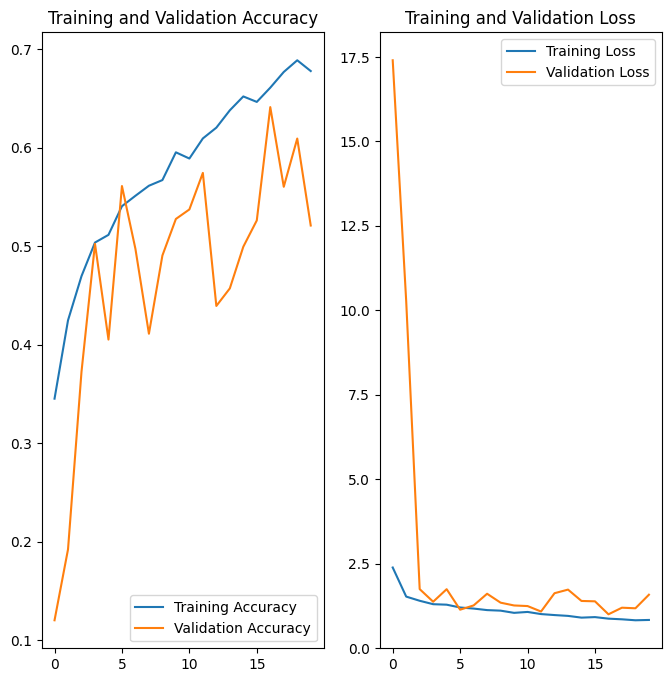

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

***Observations:***

1.Training and Validation Accuracy:

Training accuracy increases steadily over epochs, eventually approaching 0.7.
Validation accuracy initially rises in sync with the training accuracy but fluctuates significantly after a few epochs. Despite this fluctuation, the overall trend shows improvement.

2.Training and Validation Loss:

Training loss decreases consistently over epochs, indicating the model is effectively learning from the training data.
Validation loss starts very high and rapidly decreases within the first few epochs. Afterward, it stabilizes with minor fluctuations, closely aligning with the training loss.

3.Findings:
Good Generalization:

The training and validation loss curves align well, with no significant gap, indicating that the model generalizes reasonably well to the validation data.
Validation accuracy closely follows the training accuracy, though fluctuations in validation accuracy suggest some instability.
No Overfitting:

The validation loss does not increase over time, ruling out overfitting.
The fluctuations in validation accuracy might indicate sensitivity to small variations in the validation data.

#### Creating another model (without batch normalization)

In [50]:
# create the model

model = Sequential([
    Input(shape=(img_height, img_width, 3)),  # Define the input shape explicitly
    augmentation_data,                       # Data augmentation layer
    layers.Rescaling(1.0 / 255),             # Rescaling layer for normalization
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),  # Use string 'relu' for readability
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),                     # Dropout for regularization
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(target_labels)             # Final output layer
])


#### Compiling the model

In [51]:
# compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# ModelCheckpoint callback is employed alongside the model.fit() training process to periodically save the model
# or its weights (in a checkpoint file)
checkpoint = ModelCheckpoint("model.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)

# Early stop the training when a monitored metric ceases to show improvement
earlystop = EarlyStopping(monitor="val_accuracy", patience=5, mode="auto", verbose=1)

#### Training the model

In [52]:
%%time
# train the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint, earlystop]
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.2211 - loss: 2.0978
Epoch 1: val_accuracy improved from -inf to 0.34298, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 45s 259ms/step - accuracy: 0.2215 - loss: 2.0966 - val_accuracy: 0.3430 - val_loss: 1.6530
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.4098 - loss: 1.5373
Epoch 2: val_accuracy improved from 0.34298 to 0.40386, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 79s 244ms/step - accuracy: 0.4099 - loss: 1.5371 - val_accuracy: 0.4039 - val_loss: 1.6410
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.4546 - loss: 1.4348
Epoch 3: val_accuracy improved from 0.40386 to 0.49517, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 39s 233ms/step - accuracy: 0.4547 - loss: 1.4346 - val_accuracy: 0.4952 - val_loss: 1.3051
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.4943 - loss: 1.3085
Epoch 4: val_accuracy improved from 0.4

In [53]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_3 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,969,405 (45.66 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,979,604 (30.44 MB)

#### Visualize the model results

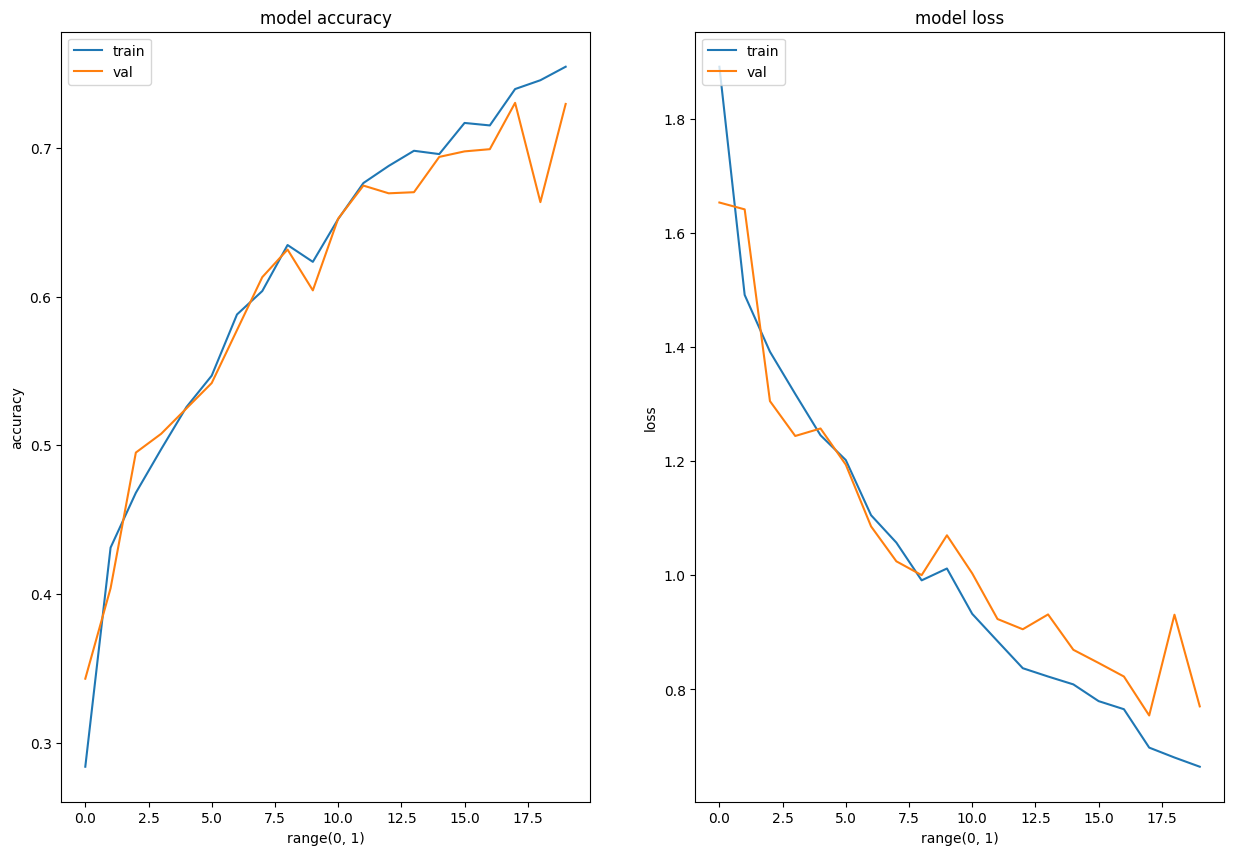

In [54]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



***Observations:***

1. Training and Validation Accuracy:
   
The training and validation accuracy show a positive trend, steadily increasing across epochs.
There is close alignment between the training and validation curves, indicating that the model is learning well and not overfitting.
Accuracy starts around 0.3 and gradually increases to around 0.75 towards the end.

2. Training and Validation Loss:
   
Both training and validation loss decrease consistently over epochs, indicating improvement in the model's performance.
There are some fluctuations in the validation loss, particularly in the middle epochs, but it generally follows the trend of the training loss.
Loss starts at around 1.8 and reduces to below 0.8, showing significant improvement.

3. Key Findings:
   
The model demonstrates good generalization as training and validation metrics are closely aligned.
There is no apparent overfitting or underfitting as both accuracy and loss trends for training and validation sets align well.
Minor fluctuations in validation loss are normal and do not indicate serious issues.

### Model Evaluation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Actual Class: nevus
Predicted Class: nevus


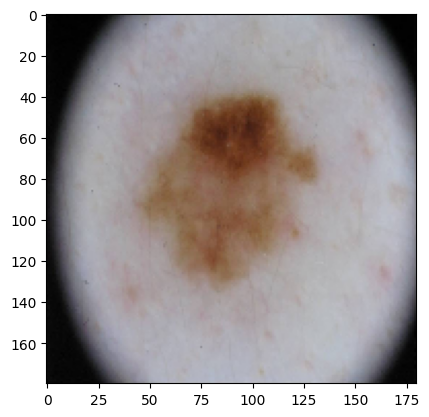

In [61]:
# Evaluating the model on one of the instances in the test set
image_path_test = os.path.join(data_dir_test, class_names[4], '*')
test_image = glob(image_path_test)
test_image = load_img(test_image[-1], target_size=(180, 180, 3))
plt.imshow(test_image)
plt.grid(False)

img = np.expand_dims(test_image, axis=0)
predicted = model.predict(img)
predicted = np.argmax(predicted)
predicted_class = class_names[predicted]
print("Actual Class: " + class_names[4] +'\n'+ "Predicted Class: " + predicted_class)